 <p style = "font-size: 35px;font-weight: bold;text-align:center;color:#800000"> Engagement/Intent Metrics vs Ecosure Violations (Brand Level) </p>

<div>
    <img src = "http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" align="left" style="height:100px;margin-right:100px">
</div>
<div>
    <img src = "https://upload.wikimedia.org/wikipedia/commons/2/26/Ecolab.svg" align="right" style="height:40px;margin-left:100px; margin-top:25px">
</div>

<p style="font-size:100%;text-align:left;font-weight:bold"> Created by  : Mu Sigma team for Ecolab
<p style="font-size:100%;text-align:left;font-weight:bold;"> Last edited : 07/05/2021

 <p style = "font-size: 20px;font-weight: bold;text-align: left;color:#000000"> Description:   </p>
 
This notebook is used to explore the relationship between the drivers and measures at a store level. We are comparing audits data with yelp intent and engagement metrics.<br>

Data Used: <br>
* For <b>Audit Information</b>, across different brands, we have used <b>Ecosure BI Data</b> stored in <b>SQLServer</b>
* For <b>Sentiment Information</b>, across different brands, we have used different review sample pulled from <b>Yelp API</b> and run a Sentiment model using Flair
* Across all 19 brands <b>("Applebee's", "Friendly's", 'IHOP,' 'Margaritaville', 'Noodles & Co.',
 'On the Border', 'Panera', 'Twin Peaks', 'Buffalo Wild Wings',
 "Famous Dave's of America,  Inc.", 'Cafe Zupas', 'Benihana National Corp',
 'WingStop', 'Texas Roadhouse', 'True Food Kitchen', 'Ruby Tuesday Inc.',
 "O'Charley's, Inc.", 'Modern Market', 'Wood Ranch')</b>

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import re
import warnings
import itertools
import datetime
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from itertools import product
from fuzzywuzzy import fuzz
from scipy import stats
from geopy.distance import geodesic
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
###################################################### REQUIRED INTERVAL #################################################
def req_intervals(x):
    if (x < -0.5) & (x > -1):
        return 'Score (-0.5 to -1)'
    elif (x < 0) & (x > -0.5):
        return 'Score (-0.5 to 0)'
    elif (x < 0.5) & (x > 0):
        return 'Score (0 to 0.5)'
    else:
        return 'Score (0.5 to 1)'
    

######################################################## HYPOTHESIS TESTING ###################################################
    
def spearman_corr(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    spearman_corr = []
    null_hypothesis = []
    alternate_hypothsesis = []
    p_val = []
    
    corr, pval = spearmanr(df_datagrouped[test_var],
                            df_datagrouped[measure])
        
    spearman_corr.append(corr)
    p_val.append(pval)
        
    # Accpeted and Rejected interchanged
    if pval < 0.10:
        null_hypothesis.append('Rejected')
        alternate_hypothsesis.append('Accepted')
    else:
        null_hypothesis.append('Accepted')
        alternate_hypothsesis.append('Rejected')

    test_df = pd.DataFrame({'Spearman Coefficient': spearman_corr,
                            'p-value': p_val,
                            'Null Hypothesis': null_hypothesis,
                            'Atlernate Hypothesis': alternate_hypothsesis})
    
    return test_df

def spearman_corr_brand(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    brands = list(df_datagrouped.Brand.unique())
    spearman_corr = []
    lengthdata = []
    
    for brand in brands:
        corr,_= pearsonr(df_datagrouped[df_datagrouped.Brand == brand][test_var], 
                         df_datagrouped[df_datagrouped.Brand == brand][measure])
        lengthdata.append(len(df_datagrouped[df_datagrouped.Brand == brand]))
        spearman_corr.append(corr)
    
    test_df = pd.DataFrame({'Brand': brands,
                            'Data Points': lengthdata,
                            'Correlation Coefficient': spearman_corr
                            })
    
    return test_df

######################################################## Correlation Matrix ###########################################################


def correlation_matrix(var, df, title):
    
    # Compute the correlation matrix
    corr_data = df[var]
    sns.set(style="white")
    corr = corr_data.corr()
    corr = corr.round(2)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 150, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                annot = True, vmin=-1)

    ax.set_title(title, fontsize=32)
    plt.show()

### Prep Processing Engagement Metrics

In [4]:
######################################################## Engagement/Intent Metrics ######################################################
#########################################################################################################################################

csv_names = ['Applebee_engagement.csv', 'Benihana_engagement.csv', 'BuffaloWildWings_engagement.csv', 'CafeZupas_engagement.csv',
             'FamousDave_engagement.csv', 'Friendly_engagement.csv', 'IHOP_engagement.csv', 'Margaritaville_engagement.csv',
             'ModernMarket_engagement.csv', 'Noodles&Co._engagement.csv', 'OCharley_engagement.csv', 'OntheBorder_engagement.csv',
             'Panera_engagement.csv', 'RubyTuesday_engagement.csv', 'TexasRoadhouse_engagement.csv', 'TrueFoodKitchen_engagement.csv',
             'TwinPeaks_engagement.csv', 'WingStop_engagement.csv', 'WoodRanch_engagement.csv']

list_metrics = []
for i in csv_names:
    list_metrics.append(pd.read_csv('/User/yelpapi/Engagement_Metric/%s' %(i)))

df_engagement = pd.concat(list_metrics)
df_engagement.drop(df_engagement.filter(regex="Unname"),axis=1, inplace=True)
df_engagement.reset_index(drop=True, inplace=True)

# Getting Month-Year from date
df_engagement['date'] = pd.to_datetime(df_engagement['metrics.start_of_week_date'], errors='coerce')
df_engagement = df_engagement[(df_engagement['date'] >= '2016-09-01') & (df_engagement['date'] < '2020-03-01')]
df_engagement['Date'] = df_engagement['date'].dt.date
df_engagement['month_year'] = df_engagement['Date'].apply(lambda x: x.strftime('%B-%Y'))

# Getting week number from date
df_engagement['Week_Number'] = df_engagement['date'].dt.week
df_engagement['Year'] = df_engagement['date'].dt.year
df_engagement['Week_No_Year'] = df_engagement['Week_Number'].astype(str) + '-' + df_engagement['Year'].astype(str)
df_engagement.reset_index(drop=True, inplace=True)

print('\nDimensions: ', df_engagement.shape)
display(df_engagement.head())

df_engagement_grouped = df_engagement.groupby(['month_year', 'Brand', 'business_id'], as_index=False).agg({'metrics.engagement_metric' : 'mean',
                                                                       'metrics.intent_metric' : 'mean'})

df_engagement_grouped.rename({'metrics.engagement_metric': 'Engagement_Metric',
                              'metrics.intent_metric': 'Intent_Metric',
                              'business_id': 'id'}, axis=1, inplace=True)

print('\nDimensions: ', df_engagement_grouped.shape)
display(df_engagement_grouped.head())



Dimensions:  (1468647, 11)


,metrics.start_of_week_date,metrics.engagement_metric,metrics.intent_metric,business_id,Brand,date,Date,month_year,Week_Number,Year,Week_No_Year
0,2017-01-02,5,1,bOcQNtpj7_QG1K2SkGL-Hw,Applebees,2017-01-02,2017-01-02,January-2017,1,2017,1-2017
1,2017-01-09,4,1,bOcQNtpj7_QG1K2SkGL-Hw,Applebees,2017-01-09,2017-01-09,January-2017,2,2017,2-2017
2,2017-01-16,4,1,bOcQNtpj7_QG1K2SkGL-Hw,Applebees,2017-01-16,2017-01-16,January-2017,3,2017,3-2017
3,2017-01-30,2,1,bOcQNtpj7_QG1K2SkGL-Hw,Applebees,2017-01-30,2017-01-30,January-2017,5,2017,5-2017
4,2017-02-06,4,1,bOcQNtpj7_QG1K2SkGL-Hw,Applebees,2017-02-06,2017-02-06,February-2017,6,2017,6-2017



Dimensions:  (340519, 5)


,month_year,Brand,id,Engagement_Metric,Intent_Metric
0,April-2017,Applebees,-EklFXamgGL2JlimOJOUNg,3.25,1.00
1,April-2017,Applebees,-GfVZKc7oZ1MYRx3MMfg1g,5.75,1.00
2,April-2017,Applebees,-IN0XtORQfosMjGKF_Th7w,5.50,1.00
3,April-2017,Applebees,-OORYytIkXipEtqffA0Lrw,4.75,1.00
4,April-2017,Applebees,-QdGL0lNezGLlkqd9AZ-Vg,2.25,1.00


#### Find median no of Engagement Metric & Intent Metric present for each store in yelp data

Median - denoting or relating to a value or quantity lying at the midpoint of a frequency distribution of observed values or quantities, such that there is an equal probability of falling above or below it.

In [5]:
df_check = df_engagement.groupby(['business_id'], as_index=False).agg({'metrics.engagement_metric' : 'mean', 'metrics.intent_metric' : 'mean'})
print("Across {siz} stores/business IDs".format(siz=df_check.shape[0]))
print("Median Engagement Metric is {} for all stores present in Yelp Data".format(round(df_check['metrics.engagement_metric'].median(),2)))
print("Median Intent Metric is {} for all stores present in Yelp Data".format(round(df_check['metrics.intent_metric'].median(),2)))

Across 7728 stores/business IDs
Median Engagement Metric is 8.43 for all stores present in Yelp Data
Median Intent Metric is 1.35 for all stores present in Yelp Data


### Pre Processing Review Data

In [6]:
df_twinpeaks_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/TwinPeaks.csv')
df_ihop_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/IHOP.csv')
df_applebees_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/Applebees.csv')
df_woodranch_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/WoodRanch.csv')
df_buffalow_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/BuffaloWildWings.csv')
df_noodles_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/NoodlesCo.csv')
df_benihana_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/BenihanaNationalCorp.csv')
df_ontheboard_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/OntheBorder.csv')
df_friendlys_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/Friendlys.csv')
df_margaritaville_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/Margaritaville.csv')
df_rubytuesday_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/RubyTuesdayInc.csv')
df_wingstop_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/WingStop.csv')
df_modmarket_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/ModernMarket.csv')
df_truefood_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/TrueFoodKitchen.csv')
df_txroadhouse_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/TexasRoadhouse.csv')
df_famousdave_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/FamousDavesofAmericaInc.csv')
df_zupas_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/CafeZupas.csv')
df_charleys_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/OCharleysInc.csv')
df_panera_merged = pd.read_csv('/User/yelpapi/Yelp_Combined/Panera.csv')

df_review = df_twinpeaks_merged.append([df_ihop_merged, df_applebees_merged, df_woodranch_merged, df_buffalow_merged,
                              df_noodles_merged, df_benihana_merged, df_ontheboard_merged, df_friendlys_merged,
                              df_margaritaville_merged, df_rubytuesday_merged, df_wingstop_merged, df_modmarket_merged,
                              df_truefood_merged, df_txroadhouse_merged, df_famousdave_merged, df_zupas_merged,
                              df_charleys_merged,df_panera_merged])

df_review = df_review.loc[:, ~df_review.columns.str.contains('^Unnamed')]
df_review = df_review[df_review['date'].notnull()]

# Getting Month-Year from date
df_review['date'] = pd.to_datetime(df_review['date'], errors='coerce')
df_review = df_review[(df_review['date'] >= '2016-09-01') & (df_review['date'] < '2020-03-01')]
df_review['Date'] = df_review['date'].dt.date
df_review['month_year'] = df_review['Date'].apply(lambda x: x.strftime('%B-%Y'))

# Getting week number from date
df_review['Week_Number'] = df_review['date'].dt.week
df_review['Year'] = df_review['date'].dt.year
df_review['Week_No_Year'] = df_review['Week_Number'].astype(str) + '-' + df_review['Year'].astype(str)
df_review.reset_index(drop=True, inplace=True)

# Adding lat long
df_review['lat_long'] = df_review['coordinates.latitude'].astype(str) + ',' + df_review['coordinates.longitude'].astype(str)

# Flags to be used in aggregation
def sentiment_check(sentiment, typeofsentiment):
    count = 0
    if(sentiment == typeofsentiment):
        count = 1
    else :
        count = 0
    return count

df_review['Negative_flag'] = df_review.apply(lambda x: sentiment_check(x['Sentiment_Type'], "Negative"), axis=1)
df_review['Positive_flag'] = df_review.apply(lambda x: sentiment_check(x['Sentiment_Type'], "Positive"), axis=1)

print('\nRaw Review Data: ', df_review.shape)
display(df_review.head(2))


Raw Review Data:  (295389, 51)


,date,rating,text,username,sourceURLs,Flair_Score,Sentiment_Type,Brand,id,alias,name,image_url,is_closed,url,review_count,categories,transactions,phone,display_phone,distance,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,attributes.ambience.touristy,attributes.ambience.hipster,attributes.ambience.romantic,attributes.ambience.divey,attributes.ambience.intimate,attributes.ambience.trendy,attributes.ambience.upscale,attributes.ambience.classy,attributes.ambience.casual,attributes.restaurants_take_out,attributes.restaurants_delivery,price,attributes.ambience,Date,month_year,Week_Number,Year,Week_No_Year,lat_long,Negative_flag,Positive_flag
0,2020-02-29 16:47:57,1.00,"Server was nice. Food was awful, we got the ri...",Kelly S.,yelp_reviews,-1.00,Negative,Twin Peaks,LZTMaQeKKHjaDBylGJxU0A,twin-peaks-san-marcos-2,Twin Peaks,https://s3-media2.fl.yelpcdn.com/bphoto/pXcWOd...,False,https://www.yelp.com/biz/twin-peaks-san-marcos...,44.00,"[{'alias': 'newamerican', 'title': 'American (...","['pickup', 'delivery']",15126677759.00,(512) 667-7759,7.41,29.87,-97.94,1207 S I-35,NaN,NaN,San Marcos,78666,US,TX,"['1207 S I-35', 'San Marcos, TX 78666']",NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,False,False,$$,NaN,2020-02-29,February-2020,9,2020,9-2020,"29.86725067,-97.93994967",1,0
1,2020-02-29 14:35:40,1.00,Hooters with a deer head. Walked in. Sat at t...,Steve V.,yelp_reviews,-1.00,Negative,Twin Peaks,LZTMaQeKKHjaDBylGJxU0A,twin-peaks-san-marcos-2,Twin Peaks,https://s3-media2.fl.yelpcdn.com/bphoto/pXcWOd...,False,https://www.yelp.com/biz/twin-peaks-san-marcos...,44.00,"[{'alias': 'newamerican', 'title': 'American (...","['pickup', 'delivery']",15126677759.00,(512) 667-7759,7.41,29.87,-97.94,1207 S I-35,NaN,NaN,San Marcos,78666,US,TX,"['1207 S I-35', 'San Marcos, TX 78666']",NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,False,False,$$,NaN,2020-02-29,February-2020,9,2020,9-2020,"29.86725067,-97.93994967",1,0


#### Mapping information to engagement data using Business IDs

In [7]:
df_grouped_review = df_review.groupby(['month_year', 'Brand', 'id', 'lat_long'], as_index=False).agg({'Flair_Score' : 'mean',
                                                                                                      'Positive_flag' : 'sum',
                                                                                                      'Negative_flag' : 'sum',
                                                                                                      'rating' : 'mean',
                                                                                                      'text' : 'count'})

df_grouped_review.rename({'text' : 'No_of_Reviews',
                          'rating' : 'Rating',
                          'Positive_flag': 'Positive_Reviews',
                          'Negative_flag': 'Negative_Reviews'}, axis=1, inplace=True)

# Calculating KPIs
df_grouped_review['Positive_Review_Percent'] = (df_grouped_review['Positive_Reviews']/df_grouped_review['No_of_Reviews'])*100
df_grouped_review['Negative_Review_Percent'] = (df_grouped_review['Negative_Reviews']/df_grouped_review['No_of_Reviews'])*100

print('\nGrouped Review Data at month year, Brand, lat_long level :', df_grouped_review.shape)
display(df_grouped_review.head())


Grouped Review Data at month year, Brand, lat_long level : (131866, 11)


,month_year,Brand,id,lat_long,Flair_Score,Positive_Reviews,Negative_Reviews,Rating,No_of_Reviews,Positive_Review_Percent,Negative_Review_Percent
0,April-2017,Applebee's,-fSp2tpieaiHOtBt7SXP9Q,"38.3585,-90.1545",-0.34,1,2,2.33,3,33.33,66.67
1,April-2017,Applebee's,-lOl6VHPFbCGK_R6r4MTxA,"33.1815,-117.344",-0.00,1,1,2.50,2,50.00,50.00
2,April-2017,Applebee's,-tQvwKXf0KAwHwX2pR1J6g,"40.253672,-76.830836",-1.00,0,1,2.00,1,0.00,100.00
3,April-2017,Applebee's,-xOnBbdyP-zBj6f5bhIrMQ,"45.449273,-122.578719",-1.00,0,2,2.00,2,0.00,100.00
4,April-2017,Applebee's,099wJ3-bFOnB7Dx0Fysvwg,"42.974762,-71.476359",0.60,4,1,4.20,5,80.00,20.00


#### Merged Engagement Table

In [8]:
print('\nEngagement Aggregated: ', df_engagement_grouped.shape)
print('\nReview Aggregated: ', df_grouped_review.shape)

df_merged_eng = pd.merge(df_engagement_grouped, df_grouped_review, on = ['month_year', 'id'], how = 'inner')

print('\nMerged Data: ', df_merged_eng.shape)

print('\n Checking for Nulls: \n', df_merged_eng.isnull().sum())
df_merged_eng = df_merged_eng[~df_merged_eng.lat_long.isnull()]

df_merged_eng.drop(columns = ['Brand_x'], inplace=True)
df_merged_eng.rename({'Brand_y' : 'Brand'}, axis=1, inplace=True)

print('\nMerged Data: ', df_merged_eng.shape)

display(df_merged_eng.head(5))


Engagement Aggregated:  (340519, 5)

Review Aggregated:  (131866, 11)

Merged Data:  (137615, 14)

 Checking for Nulls: 
 month_year                 0
Brand_x                    0
id                         0
Engagement_Metric          0
Intent_Metric              0
Brand_y                    0
lat_long                   0
Flair_Score                0
Positive_Reviews           0
Negative_Reviews           0
Rating                     0
No_of_Reviews              0
Positive_Review_Percent    0
Negative_Review_Percent    0
dtype: int64

Merged Data:  (137615, 13)


,month_year,id,Engagement_Metric,Intent_Metric,Brand,lat_long,Flair_Score,Positive_Reviews,Negative_Reviews,Rating,No_of_Reviews,Positive_Review_Percent,Negative_Review_Percent
0,April-2017,-fSp2tpieaiHOtBt7SXP9Q,2.33,1.00,Applebee's,"38.3585,-90.1545",-0.34,1,2,2.33,3,33.33,66.67
1,April-2017,-lOl6VHPFbCGK_R6r4MTxA,14.50,5.25,Applebee's,"33.1815,-117.344",-0.00,1,1,2.50,2,50.00,50.00
2,April-2017,-tQvwKXf0KAwHwX2pR1J6g,6.50,1.00,Applebee's,"40.253672,-76.830836",-1.00,0,1,2.00,1,0.00,100.00
3,April-2017,-xOnBbdyP-zBj6f5bhIrMQ,9.25,2.25,Applebee's,"45.449273,-122.578719",-1.00,0,2,2.00,2,0.00,100.00
4,April-2017,099wJ3-bFOnB7Dx0Fysvwg,6.50,1.00,Applebee's,"42.974762,-71.476359",0.60,4,1,4.20,5,80.00,20.00


## Audit Data

In [9]:
######################################################### Audit Data ###################################################################
########################################################################################################################################
# read aggregated audit data
df_audit = pd.read_csv('/User/csv/Audit/Ecosure_Processed-0.csv')
df_audit.drop(df_audit.filter(regex="Unname"),axis=1, inplace=True)

# Aggregating data at month year level
df_audit['AuditStarted'] = pd.to_datetime(df_audit['AuditStarted'], errors='coerce')
df_audit = df_audit[(df_audit['AuditStarted'] >= '2016-09-01') & (df_audit['AuditStarted'] < '2020-03-01')]
df_audit = df_audit[df_audit.AuditStarted.notnull()]
df_audit['Date'] = df_audit['AuditStarted'].dt.date
df_audit['month_year'] = df_audit['AuditStarted'].apply(lambda x: x.strftime('%B-%Y'))

df_audit['Week_Number'] = df_audit['AuditStarted'].dt.week
df_audit['Year'] = df_audit['AuditStarted'].dt.year
df_audit['Week_No_Year'] = df_audit['Week_Number'].astype(str) + '-' + df_audit['Year'].astype(str)

df_audit['Brand'] = df_audit['ClientName']
df_audit['lat_long'] = df_audit['Latitude'].astype(str) + ',' + df_audit['Longitude'].astype(str)

# Adding KPI
df_audit['Total_No_of_Violations_per_question'] = df_audit['Total_Violations']/df_audit['count_questions']

df_audit.dropna(subset=['Latitude', 'Longitude'], how='all', inplace=True)

print('\nRaw Audit Data: ', df_audit.shape)
display(df_audit.head())

df_violations = df_audit.groupby(['month_year','ClientName', 'lat_long'], as_index=False).agg({'Total_No_of_Violations_per_question' : 'mean',
                                                                                               'TranslatedScore' : 'mean', 
                                                                                               'ClientID' : 'count'})

# Renaming Columns
df_violations.rename({'TranslatedScore' : 'Mean_Audit_Score',
                      'ClientName' : 'Brand',
                      'ClientID' : 'No_of_Audits'},axis=1, inplace=True)

print('\nGrouped Audit Data at month year, Brand, lat_long level : ', df_violations.shape)
display(df_violations.head())


Raw Audit Data:  (98533, 51)


,ClientID,ClientName,ServiceLocationID,UnitNbr,Address1,Address2,StoreName,City,StoreType,StoreStatus,Franchisee,ConceptName,State,Country,Zipcode,Latitude,Longitude,AuditID,ReferenceNumber,AuditCycle,VisitNumber,AuditStarted,AuditEnded,EffectiveFrom,CalenderYear,CalenderMonth,CalenderMonthName,ClientType,YearName,ReportingYear,ReportingMonthName,ReportingMonth,AuditNotes,InspectionType,DWActRecInd,PreviousAuditID,AuditOrder,AuditKey,ServiceLocationKey,TranslatedScore,TranslatedRating,Total_Violations,count_questions,Date,month_year,Week_Number,Year,Week_No_Year,Brand,lat_long,Total_No_of_Violations_per_question
0,2,Applebee's,185463,83024,1650 Tappahannock Blvd.,,TAPPAHANNOCK,Tappahannock,Franchise,Open,POTOMAC FAMILY DINING GROUP OC LLC,Applebee's,VA,USA,22560,37.91,-76.86,3679337,AB2016FS,2.00,1.00,2016-09-11 14:30:00,2016-09-11 16:11:51.000,2016-10-14 10:55:16.397,2016.00,9.00,September,FSR,2016,2016.00,period9,9.00,NaN,NaN,Y,3491189.00,3.00,-7545654929276035072.00,-7042526500281117696.00,90.00,Pass,4.00,135.00,2016-09-11,September-2016,36,2016,36-2016,Applebee's,"37.906682,-76.864294",0.03
1,2,Applebee's,101247,94019,101 Lee Blvd,,SHELBYVILLE,Shelbyville,Franchise,Open,"APPLE AMERICAN GROUP, LLC",Applebee's,IN,USA,46176,39.53,-85.74,3679678,AB2016FS,2.00,1.00,2016-09-11 13:51:00,2016-09-11 15:25:41.000,2016-10-14 10:55:16.397,2016.00,9.00,September,FSR,2016,2016.00,period9,9.00,NaN,NaN,Y,3513878.00,3.00,2684201522030720512.00,-6597523581081518080.00,95.00,Pass,2.00,135.00,2016-09-11,September-2016,36,2016,36-2016,Applebee's,"39.526095,-85.738668",0.01
2,139,IHOP,1037440,360083,1425 South Federal Highway,NaN,STUART,STUART,Franchise,Open,Daniel Enea,IHOP,FL,USA,34994,27.19,-80.24,3679713,IH2016FL,2.00,1.00,2016-09-12 09:13:00,2016-09-12 11:02:37.000,2016-10-14 10:55:16.397,2016.00,9.00,September,FSR,2016,2016.00,period9,9.00,NaN,NaN,Y,3476410.00,3.00,-6223326056079611904.00,-4695846108124093440.00,80.00,Pass,5.00,133.00,2016-09-12,September-2016,37,2016,37-2016,IHOP,"27.185266,-80.243879",0.04
3,139,IHOP,1139181,5616,301 Main Street,Suite 180-182,Paterson,Paterson,Franchise,Open,Adenah Bayoh,IHOP,NJ,USA,07111,40.91,-74.17,3679714,IH2016FS,3.00,1.00,2016-09-12 09:04:00,2016-09-12 10:37:00.000,2016-10-14 10:55:16.397,2016.00,9.00,September,FSR,2016,2016.00,period9,9.00,NaN,NaN,Y,3615096.00,4.00,7448285683969546240.00,-8942759154655554560.00,100.00,Pass,3.00,133.00,2016-09-12,September-2016,37,2016,37-2016,IHOP,"40.914891,-74.173345",0.02
5,139,IHOP,443416,4494,3636 Parkway,NaN,Pigeon Forge,Pigeon Forge,Franchise,Open,Gary Wade,IHOP,TN,USA,37863,35.78,-83.55,3679835,IH2016FS,3.00,1.00,2016-09-12 08:18:00,2016-09-12 10:06:34.000,2016-10-14 10:55:16.397,2016.00,9.00,September,FSR,2016,2016.00,period9,9.00,NaN,NaN,Y,3590596.00,4.00,5808780972492866560.00,-1911692229305007616.00,85.00,Pass,6.00,133.00,2016-09-12,September-2016,37,2016,37-2016,IHOP,"35.783122,-83.551424",0.05



Grouped Audit Data at month year, Brand, lat_long level :  (84915, 6)


,month_year,Brand,lat_long,Total_No_of_Violations_per_question,Mean_Audit_Score,No_of_Audits
0,April-2017,Applebee's,"25.576785,-80.37119",0.01,90.00,1
1,April-2017,Applebee's,"25.920901,-97.477296",0.07,85.50,1
2,April-2017,Applebee's,"26.1906,-97.711513",0.09,86.50,1
3,April-2017,Applebee's,"26.209998,-81.7683",0.04,91.50,1
4,April-2017,Applebee's,"26.451288,-80.14686",0.02,87.50,1


## Lat/Long Matching

In [10]:
df_mapping_all = pd.read_csv('/User/StoreLevelMaping/MASTER_LatlongMappings.csv')

df_mapping_all.drop(df_mapping_all.filter(regex="Unname"),axis=1, inplace=True)

print('Mapping table dimensions: ', df_mapping_all.shape)
display(df_mapping_all.head())

Mapping table dimensions:  (11554606, 4)


,LatLong_audit,LatLong_review,distance,Brand
0,"37.906682,-76.864294","28.515792,-81.45831700000002",699.50,Applebee's
1,"37.906682,-76.864294","28.4603082,-81.46791999999998",703.27,Applebee's
2,"37.906682,-76.864294","33.497638,-86.877137",639.36,Applebee's
3,"37.906682,-76.864294","44.974375,-93.229615",977.20,Applebee's
4,"37.906682,-76.864294","45.011121,-93.179954",976.02,Applebee's


### Level1 : Mapped month year, Brand, Lat long (store) combinations for different Distance ranges

In [11]:
brands =  list(df_audit.Brand.unique())

results_dict = {}
results_dict['Brand'] = []
results_dict['Audit Data'] = []
results_dict['Audit Data (Unique Lat Long)'] = []
results_dict['Review Data'] = []
results_dict['Review Data (Unique Lat Long)'] = []
results_dict['Distance_Mapping']= []
results_dict['After Merge']= []
results_dict['After Merge (Unique Lat Long)']= []
results_dict['Mapping Data'] = []
results_dict['Mapping Data Agg'] = []
results_dict['Mapping Nulls'] = []
results_dict['Matches'] = []
results_dict['Matches_with_review'] = []

df_merged = pd.DataFrame()


for brand in brands:
    # Existing data
    df_curr_audit = df_violations[df_violations.Brand == brand].copy(deep=True)
    df_curr_review = df_merged_eng[df_merged_eng.Brand == brand].copy(deep=True)
    
    # Mapping data
    df_map_1 = df_mapping_all[(df_mapping_all.Brand == brand) & (df_mapping_all.distance < 2)].copy(deep=True)
    df_map = df_map_1.sort_values(['LatLong_review','distance'],ascending=True).groupby('LatLong_review').head(1)
    
    # Defining mapping dictionary
    dict_map = dict(zip(df_map.LatLong_review, df_map.LatLong_audit))
    dict_map_dist = dict(zip(df_map.LatLong_review, df_map.distance))
    
    results_dict['Matches_with_review'].append(df_curr_review[df_curr_review.lat_long.isin(list(df_map.LatLong_review.unique()))].shape[0])
    
    df_curr_review['lat_long_distance'] = df_curr_review['lat_long'].map(dict_map_dist)
    df_curr_review['lat_long'] = df_curr_review['lat_long'].map(dict_map)
    
    # Merging
    df_merge = pd.DataFrame()
    df_merge = pd.merge(df_curr_audit, df_curr_review, how='inner', on=['month_year','Brand', 'lat_long'])
    matched_lat_long = list(df_merge.lat_long.unique())
    
    df_merge['Distance_Mapping'] = 2
    df_merged = df_merged.append(df_merge)
    
    # Recording mapping status
    results_dict['Brand'].append(brand)
    results_dict['Distance_Mapping'].append(2)
    results_dict['Audit Data'].append(df_curr_audit.shape[0])
    results_dict['Audit Data (Unique Lat Long)'].append(df_curr_audit.lat_long.nunique())
    results_dict['Review Data'].append(df_curr_review.shape[0])
    results_dict['Review Data (Unique Lat Long)'].append(df_curr_review.lat_long.nunique())
    results_dict['After Merge'].append(df_merge.shape[0])
    results_dict['After Merge (Unique Lat Long)'].append(df_merge.lat_long.nunique())
    results_dict['Mapping Data'].append(df_map_1.shape[0])
    results_dict['Mapping Data Agg'].append(df_map.shape[0])
    results_dict['Mapping Nulls'].append(df_curr_review['lat_long'].isnull().sum())
    results_dict['Matches'].append(len(dict_map))    
    

In [12]:
pd.DataFrame.from_dict(results_dict,orient='index').transpose().groupby('Distance_Mapping').agg({'Audit Data':'sum',
                                                                                                 'Review Data':'sum',
                                                                                                 'After Merge':'sum',
                                                                                                 'Audit Data (Unique Lat Long)':'sum',
                                                                                                 'Review Data (Unique Lat Long)':'sum',
                                                                                                 'After Merge (Unique Lat Long)':'sum',                                            
                                                                                                 }).reset_index()

,Distance_Mapping,Audit Data,Review Data,After Merge,Audit Data (Unique Lat Long),Review Data (Unique Lat Long),After Merge (Unique Lat Long)
0,2,84915,137264,19043,9618,5182,3725


In [13]:
df_merged.head()

,month_year,Brand,lat_long,Total_No_of_Violations_per_question,Mean_Audit_Score,No_of_Audits,id,Engagement_Metric,Intent_Metric,Flair_Score,Positive_Reviews,Negative_Reviews,Rating,No_of_Reviews,Positive_Review_Percent,Negative_Review_Percent,lat_long_distance,Distance_Mapping
0,April-2017,Applebee's,"26.1906,-97.711513",0.09,86.50,1,vbhMj7EAHWGSeRgzMu9qjQ,4.50,1.00,-1.00,0,1,1.00,1,0.00,100.00,0.04,2
1,April-2017,Applebee's,"27.638641,-80.440652",0.05,89.00,1,fkjZY7dGcuSkUFTZuapL9Q,5.50,1.00,-1.00,0,3,1.00,3,0.00,100.00,0.03,2
2,April-2017,Applebee's,"27.791615000000004,-82.340691",0.06,86.00,1,LjuVfaLEIqbHF6l8hU-kxg,9.50,1.00,-0.99,0,2,2.00,2,0.00,100.00,0.04,2
3,April-2017,Applebee's,"27.893525,-82.519277",0.04,92.50,1,lLhm-u5kDFVHViFAFHDFqQ,8.25,1.00,-0.33,1,2,2.00,3,33.33,66.67,0.11,2
4,April-2017,Applebee's,"28.045561,-82.582984",0.04,89.50,1,_PJRuNpXHmPCv9eGXA3sxg,8.75,2.25,-0.01,1,1,3.50,2,50.00,50.00,0.03,2


In [14]:
print("Total No of brands retained :", df_merged.Brand.nunique())
print('\n \n')
print("Name's of the brands used for analysis:", list(df_merged.Brand.unique()))

Total No of brands retained : 16

 

Name's of the brands used for analysis: ["Applebee's", 'IHOP', 'Margaritaville', 'Noodles & Co.', 'Buffalo Wild Wings', 'Twin Peaks', 'On the Border', 'Panera', "Famous Dave's of America,  Inc.", 'Cafe Zupas', 'Benihana National Corp', 'WingStop', 'Texas Roadhouse', 'Ruby Tuesday Inc.', "O'Charley's, Inc.", 'Modern Market']


## Approach 1: Brand Level Analysis
### Ranked Correlation Analysis

In [15]:
def spearmanr_corr_brand(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    from scipy.stats import spearmanr
    brands = list(df_datagrouped.Brand.unique())
    spearman_corr, p_values = [], []
    lengthdata = []
    
    for brand in brands:
        corr,p = spearmanr(np.array(df_datagrouped[df_datagrouped.Brand == brand][test_var]), 
                         np.array(df_datagrouped[df_datagrouped.Brand == brand][measure]))
        lengthdata.append(len(df_datagrouped[df_datagrouped.Brand == brand]))
        spearman_corr.append(corr)
        p_values.append(p)
    
    test_df = pd.DataFrame({'Brand': brands,
                            'Data Points': lengthdata,
                            'P Values': p_values,
                            'Correlation Coefficient': spearman_corr
                            })
    # inplace
    test_df.replace(np.nan, 0, inplace=True)
    
    return test_df

### Total No of Violations per Question vs Sentiment Score

<b>6 out of the 18 brands show negative correlations with Engagement Metric </b>

In [16]:
spearmanr_corr_brand(df_merged, 'Total_No_of_Violations_per_question', 'Engagement_Metric')

,Brand,Data Points,P Values,Correlation Coefficient
0,Applebee's,3016,0.00,-0.12
1,IHOP,5852,0.00,-0.10
2,Margaritaville,122,0.01,0.23
3,Noodles & Co.,1707,0.00,-0.12
4,Buffalo Wild Wings,911,0.16,-0.05
5,Twin Peaks,412,0.18,0.07
6,On the Border,454,0.33,0.05
7,Panera,5347,0.00,0.05
8,"Famous Dave's of America, Inc.",358,0.86,0.01
9,Cafe Zupas,297,0.00,-0.42


### Total No of Violations per Question vs Ratings

<b>7 out of the 18 brands show negative correlations with Intent Metric from Yelp </b>

In [17]:
spearmanr_corr_brand(df_merged, 'Total_No_of_Violations_per_question', 'Intent_Metric')

,Brand,Data Points,P Values,Correlation Coefficient
0,Applebee's,3016,0.00,-0.13
1,IHOP,5852,0.00,-0.12
2,Margaritaville,122,0.01,0.24
3,Noodles & Co.,1707,0.00,-0.07
4,Buffalo Wild Wings,911,0.59,-0.02
5,Twin Peaks,412,0.59,0.03
6,On the Border,454,0.21,0.06
7,Panera,5347,0.00,0.05
8,"Famous Dave's of America, Inc.",358,0.79,-0.01
9,Cafe Zupas,297,0.00,-0.38


# Approach 3: Across Brands 

Key Messages-
* From Correlation Matrix with Initial Dataset, there is <b> some negative correlation between Violations per Audit and Customer Sentiment Measures</b>
* With more <b>Refined Dataset</b>, the <b>correlation do not become strong between our Drivers(Mean Audit Score, Violations per question) and Measures of Delighted Guests(Sentiment Score, Ratings) </b>

In [18]:
def add_lag_lead(df, var_name, brand_name):
    df = df[df['Brand'] == brand_name].reset_index(drop=True)
    df[var_name+"_lag1"] = df[var_name].shift(1)
    df[var_name+"_lead1"] = df[var_name].shift(-1)
    df[var_name+"_lag2"] = df[var_name].shift(2)
    df[var_name+"_lead2"] = df[var_name].shift(-2)
    df[var_name+"_lag3"] = df[var_name].shift(3)
    df[var_name+"_lead3"] = df[var_name].shift(-3)
    
    return df

def add_only_lag_lead(df, var_name):
    df[var_name+"_lag1"] = df[var_name].shift(1)
    df[var_name+"_lead1"] = df[var_name].shift(-1)
    df[var_name+"_lag2"] = df[var_name].shift(2)
    df[var_name+"_lead2"] = df[var_name].shift(-2)
    df[var_name+"_lag3"] = df[var_name].shift(3)
    df[var_name+"_lead3"] = df[var_name].shift(-3)
    
    return df

In [19]:
df_applebee = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "Applebee's")
df_applebee = add_only_lag_lead(df_applebee, 'Mean_Audit_Score')
df_fd = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "Famous Dave's of America,  Inc.")
df_fd = add_only_lag_lead(df_fd, 'Mean_Audit_Score')
df_f = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "Friendly's")
df_f = add_only_lag_lead(df_f, 'Mean_Audit_Score')
df_ihop = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'IHOP')
df_ihop = add_only_lag_lead(df_ihop, 'Mean_Audit_Score')
df_mar = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Margaritaville')
df_mar = add_only_lag_lead(df_mar, 'Mean_Audit_Score')
df_noo = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Noodles & Co.')
df_noo = add_only_lag_lead(df_noo, 'Mean_Audit_Score')
df_otb = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'On the Border')
df_otb = add_only_lag_lead(df_otb, 'Mean_Audit_Score')
df_pan = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Panera')
df_pan = add_only_lag_lead(df_pan, 'Mean_Audit_Score')
df_twi = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Twin Peaks') 
df_twi = add_only_lag_lead(df_twi, 'Mean_Audit_Score')
df_bww = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Buffalo Wild Wings') 
df_bww = add_only_lag_lead(df_bww, 'Mean_Audit_Score')
df_cz = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Cafe Zupas')
df_cz = add_only_lag_lead(df_cz, 'Mean_Audit_Score')
df_ws = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'WingStop')
df_ws = add_only_lag_lead(df_ws, 'Mean_Audit_Score')
df_tr = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Texas Roadhouse')
df_tr = add_only_lag_lead(df_tr, 'Mean_Audit_Score')
df_tfk = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'True Food Kitchen')
df_tfk = add_only_lag_lead(df_tfk, 'Mean_Audit_Score')
df_rt = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Ruby Tuesday Inc.')
df_rt = add_only_lag_lead(df_rt, 'Mean_Audit_Score')
df_oc = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', "O'Charley's, Inc.")
df_oc = add_only_lag_lead(df_oc, 'Mean_Audit_Score')
df_mm = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Modern Market')
df_mm = add_only_lag_lead(df_mm, 'Mean_Audit_Score')
df_beni = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Benihana National Corp')
df_beni = add_only_lag_lead(df_beni, 'Mean_Audit_Score')
df_wr = add_lag_lead(df_merged, 'Total_No_of_Violations_per_question', 'Wood Ranch')
df_wr = add_only_lag_lead(df_wr, 'Mean_Audit_Score')

In [20]:
df_merged_1 = df_applebee.append([df_fd, df_f, df_ihop, df_mar,
                                  df_noo, df_otb, df_pan, df_twi,
                                  df_bww, df_cz, df_ws, df_tr,
                                  df_tfk, df_rt, df_oc, df_mm,
                                  df_beni, df_wr])
df_merged_1.dropna(axis=0, how='any', inplace=True)
df_merged_1.reset_index(drop=True, inplace=True)

In [21]:
df_merged_1.columns

Index(['month_year', 'Brand', 'lat_long', 'Total_No_of_Violations_per_question', 'Mean_Audit_Score', 'No_of_Audits', 'id', 'Engagement_Metric', 'Intent_Metric', 'Flair_Score', 'Positive_Reviews', 'Negative_Reviews', 'Rating', 'No_of_Reviews', 'Positive_Review_Percent', 'Negative_Review_Percent', 'lat_long_distance', 'Distance_Mapping', 'Total_No_of_Violations_per_question_lag1', 'Total_No_of_Violations_per_question_lead1', 'Total_No_of_Violations_per_question_lag2', 'Total_No_of_Violations_per_question_lead2', 'Total_No_of_Violations_per_question_lag3', 'Total_No_of_Violations_per_question_lead3', 'Mean_Audit_Score_lag1', 'Mean_Audit_Score_lead1', 'Mean_Audit_Score_lag2', 'Mean_Audit_Score_lead2', 'Mean_Audit_Score_lag3', 'Mean_Audit_Score_lead3'], dtype='object')

##  Correlation Matrix

### Data Aggregated at Month Year, Brand & Location Level

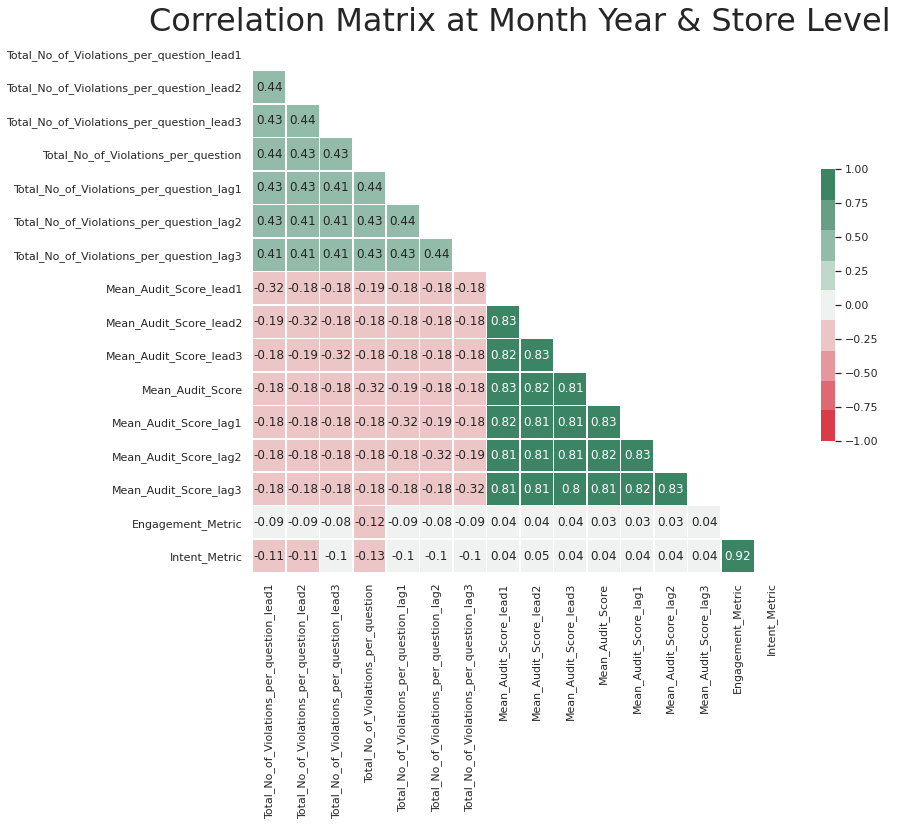

In [22]:
var = ['Total_No_of_Violations_per_question_lead1', 'Total_No_of_Violations_per_question_lead2',
       'Total_No_of_Violations_per_question_lead3', 'Total_No_of_Violations_per_question',
       'Total_No_of_Violations_per_question_lag1', 'Total_No_of_Violations_per_question_lag2',
       'Total_No_of_Violations_per_question_lag3', 'Mean_Audit_Score_lead1', 'Mean_Audit_Score_lead2',
       'Mean_Audit_Score_lead3', 'Mean_Audit_Score', 'Mean_Audit_Score_lag1', 'Mean_Audit_Score_lag2', 
       'Mean_Audit_Score_lag3', 'Engagement_Metric', 'Intent_Metric']

correlation_matrix(var, df_merged_1, "Correlation Matrix at Month Year & Store Level")